# Модель определения стоимости автомобилей

Заказчик: онлайн-сервис по продаже автомобилей с пробегом.

Необходимо построить модель для определения рыночной стоимости автомобиля.

Заказчиком предоставлены исторические данные: технические характеристики, комплектации и цены автомобилей. 

Заказчику важны следующие качества модели:
- качество предсказания;
- скорость предсказания;
- время обучения.

Признаки
* DateCrawled — дата скачивания анкеты из базы
* VehicleType — тип автомобильного кузова
* RegistrationYear — год регистрации автомобиля
* Gearbox — тип коробки передач
* Power — мощность (л. с.)
* Model — модель автомобиля
* Kilometer — пробег (км)
* RegistrationMonth — месяц регистрации автомобиля
* FuelType — тип топлива
* Brand — марка автомобиля
* NotRepaired — была машина в ремонте или нет
* DateCreated — дата создания анкеты
* NumberOfPictures — количество фотографий автомобиля
* PostalCode — почтовый индекс владельца анкеты (пользователя)
* LastSeen — дата последней активности пользователя

Целевой признак

* Price — цена (евро)

## Подготовка данных

### Шаг 1.1 Загрузка и первичный анализ данных

In [1]:
# импорты и общие настройки проекта
import pandas as pd
import time

#import math
import seaborn as sns
sns.set(color_codes=True)
sns.set_style('darkgrid')

%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np

# sklearn
from sklearn.preprocessing import OrdinalEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
from sklearn.metrics import make_scorer
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.dummy import DummyRegressor
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor

import lightgbm as lgb
from lightgbm import LGBMRegressor
from catboost import CatBoostRegressor

#включим отображение всех столбцов таблиц и округлим числа до тысячных
pd.set_option('display.max_columns', None)
pd.options.display.max_colwidth = 80
pd.options.display.float_format = '{:,.3f}'.format

In [2]:
# загружаем файл с данными
try:
    df = pd.read_csv('datasets/data_14/autos.csv', sep=',') # locally hosted datafile ## , sep='\t'
except:
    df = pd.read_csv('/datasets/autos.csv', sep=',') # Yandex-hosted datafile  ## , sep='\t'

# общий анализ структуры и состава загруженного файла
df.info()
display(df.sample(5))
display(df.describe())
print('\nПолных дубликатов:', df.duplicated().sum())
if(df.duplicated().sum()):
    display(df[df.duplicated(keep=False)])
#print("\nЧисло пропусков в данных:\n", df.isna().sum())

print("Максимальная дата обхода базы: ", df['DateCrawled'].max())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 354369 entries, 0 to 354368
Data columns (total 16 columns):
 #   Column             Non-Null Count   Dtype 
---  ------             --------------   ----- 
 0   DateCrawled        354369 non-null  object
 1   Price              354369 non-null  int64 
 2   VehicleType        316879 non-null  object
 3   RegistrationYear   354369 non-null  int64 
 4   Gearbox            334536 non-null  object
 5   Power              354369 non-null  int64 
 6   Model              334664 non-null  object
 7   Kilometer          354369 non-null  int64 
 8   RegistrationMonth  354369 non-null  int64 
 9   FuelType           321474 non-null  object
 10  Brand              354369 non-null  object
 11  NotRepaired        283215 non-null  object
 12  DateCreated        354369 non-null  object
 13  NumberOfPictures   354369 non-null  int64 
 14  PostalCode         354369 non-null  int64 
 15  LastSeen           354369 non-null  object
dtypes: int64(7), object(

,DateCrawled,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,NotRepaired,DateCreated,NumberOfPictures,PostalCode,LastSeen
63754,2016-03-27 16:51:33,10999,wagon,2009,auto,170,c_klasse,125000,6,gasoline,mercedes_benz,no,2016-03-27 00:00:00,0,97084,2016-04-05 12:44:22
250959,2016-04-02 00:56:36,2200,sedan,2002,manual,211,vectra,150000,7,petrol,opel,no,2016-04-02 00:00:00,0,74177,2016-04-06 06:15:46
292726,2016-03-31 12:49:18,9999,small,2011,manual,90,a1,125000,10,gasoline,audi,no,2016-03-31 00:00:00,0,6542,2016-04-06 05:17:51
87703,2016-03-12 14:52:25,9900,wagon,2009,manual,140,insignia,70000,5,petrol,opel,no,2016-03-12 00:00:00,0,72510,2016-04-04 22:44:58
215045,2016-04-01 12:25:24,2700,coupe,1999,auto,0,3er,150000,5,petrol,bmw,NaN,2016-04-01 00:00:00,0,65201,2016-04-06 05:15:58


,Price,RegistrationYear,Power,Kilometer,RegistrationMonth,NumberOfPictures,PostalCode
count,"354,369.000","354,369.000","354,369.000","354,369.000","354,369.000","354,369.000","354,369.000"
mean,"4,416.657","2,004.234",110.094,"128,211.173",5.715,0.000,"50,508.689"
std,"4,514.159",90.228,189.850,"37,905.342",3.726,0.000,"25,783.096"
min,0.000,"1,000.000",0.000,"5,000.000",0.000,0.000,"1,067.000"
25%,"1,050.000","1,999.000",69.000,"125,000.000",3.000,0.000,"30,165.000"
50%,"2,700.000","2,003.000",105.000,"150,000.000",6.000,0.000,"49,413.000"
75%,"6,400.000","2,008.000",143.000,"150,000.000",9.000,0.000,"71,083.000"
max,"20,000.000","9,999.000","20,000.000","150,000.000",12.000,0.000,"99,998.000"



Полных дубликатов: 4


,DateCrawled,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,NotRepaired,DateCreated,NumberOfPictures,PostalCode,LastSeen
41529,2016-03-18 18:46:15,1999,wagon,2001,manual,131,passat,150000,7,gasoline,volkswagen,no,2016-03-18 00:00:00,0,36391,2016-03-18 18:46:15
88087,2016-03-08 18:42:48,1799,coupe,1999,auto,193,clk,20000,7,petrol,mercedes_benz,no,2016-03-08 00:00:00,0,89518,2016-03-09 09:46:57
90964,2016-03-28 00:56:10,1000,small,2002,manual,83,other,150000,1,petrol,suzuki,no,2016-03-28 00:00:00,0,66589,2016-03-28 08:46:21
171088,2016-03-08 18:42:48,1799,coupe,1999,auto,193,clk,20000,7,petrol,mercedes_benz,no,2016-03-08 00:00:00,0,89518,2016-03-09 09:46:57
187735,2016-04-03 09:01:15,4699,coupe,2003,auto,218,clk,125000,6,petrol,mercedes_benz,yes,2016-04-03 00:00:00,0,75196,2016-04-07 09:44:54
231258,2016-03-28 00:56:10,1000,small,2002,manual,83,other,150000,1,petrol,suzuki,no,2016-03-28 00:00:00,0,66589,2016-03-28 08:46:21
258109,2016-04-03 09:01:15,4699,coupe,2003,auto,218,clk,125000,6,petrol,mercedes_benz,yes,2016-04-03 00:00:00,0,75196,2016-04-07 09:44:54
325651,2016-03-18 18:46:15,1999,wagon,2001,manual,131,passat,150000,7,gasoline,volkswagen,no,2016-03-18 00:00:00,0,36391,2016-03-18 18:46:15


Максимальная дата обхода базы:  2016-04-07 14:36:58


<AxesSubplot:>

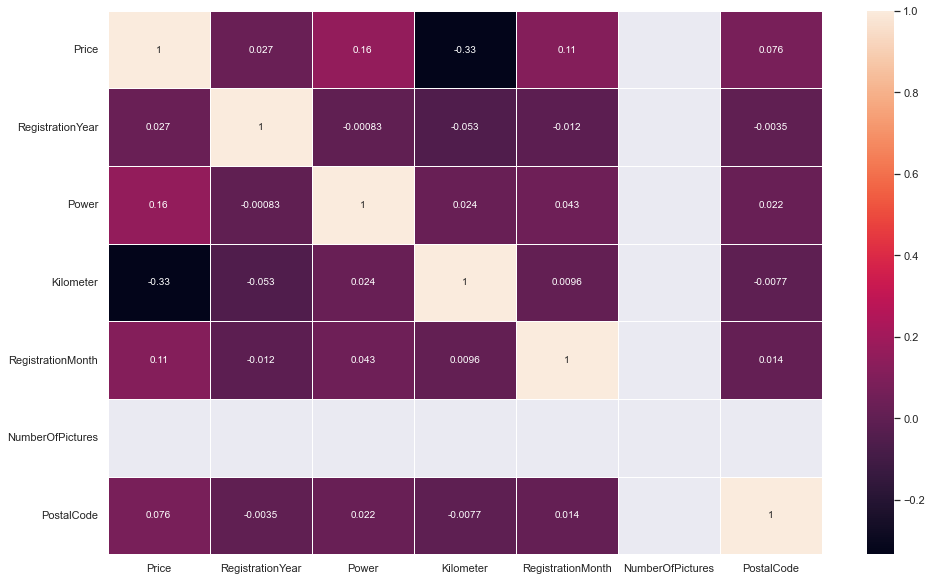

In [3]:
plt.rcParams['figure.figsize'] = (16.0, 10.0)
sns.heatmap(df.corr(), annot=True, linewidths=1, linecolor='white')

### Выводы по шагу 1.1

<div class="alert alert-block alert-info">
    <b class="alert-heading"></b>
</div>

Загрузка и предварительный анализ
* Колонки поименованы в нотации Camel Case, Это не мешает дальнейшей работе.
* Выявлено четыре набора полных дубликатов
* Выявлены выбросы в цене (нулевые и сверхвысокие цены), средние значения смещены в сторону увеличения. Высокая цена может быть у небольшого количества раритетных моделей, в этом случае важно определиться, стоит ли её включать в обучение.
* Факторы "год регистрации" и "мощность двигателя" содержат значения с обеих сторон распределения, имеющие сомнительный физический смысл.
* Выявлены пропуски в данных факторов VehicleType, Gearbox, Model, FuelType, NotRepaired
* Часть колонок (DateCrawled, DateCreated, PostalCode, LastSeen, NumberOfPictures) является метаданными и должна быть удалена перед обучением моделей.
* Выявлены корреляции цены и пробега, мощности двигателя и месяца регистрации.

    
Проведём исследовательский анализ данных по выявленным особенностям

### Шаг 1.2 Исследовательский анализ и предобработка данных

In [4]:
meta_fields = ['DateCrawled', 'DateCreated', 'PostalCode', 'LastSeen', 'NumberOfPictures']
df = df.drop(meta_fields, axis=1)
df.head(5)

,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,NotRepaired
0,480,NaN,1993,manual,0,golf,150000,0,petrol,volkswagen,NaN
1,18300,coupe,2011,manual,190,NaN,125000,5,gasoline,audi,yes
2,9800,suv,2004,auto,163,grand,125000,8,gasoline,jeep,NaN
3,1500,small,2001,manual,75,golf,150000,6,petrol,volkswagen,no
4,3600,small,2008,manual,69,fabia,90000,7,gasoline,skoda,no


#### 1.2.1 Заполнение пропусков

Заполним ключевые недостающие данные по модальному значению комбинации бренда и модели.  

In [5]:
def fillna_conditional(column):
    df[column] = df[column].fillna(df.groupby(['Brand','Model'], dropna=False)[column].transform(lambda x: x.mode()[0]))

In [6]:
fillna_conditional('VehicleType')
fillna_conditional('FuelType')
fillna_conditional('Gearbox')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 354369 entries, 0 to 354368
Data columns (total 11 columns):
 #   Column             Non-Null Count   Dtype 
---  ------             --------------   ----- 
 0   Price              354369 non-null  int64 
 1   VehicleType        354369 non-null  object
 2   RegistrationYear   354369 non-null  int64 
 3   Gearbox            354369 non-null  object
 4   Power              354369 non-null  int64 
 5   Model              334664 non-null  object
 6   Kilometer          354369 non-null  int64 
 7   RegistrationMonth  354369 non-null  int64 
 8   FuelType           354369 non-null  object
 9   Brand              354369 non-null  object
 10  NotRepaired        283215 non-null  object
dtypes: int64(5), object(6)
memory usage: 29.7+ MB


#### 1.2.2 Заполнение остальных факторов с пропусками

In [7]:
df['NotRepaired'].value_counts(dropna=False)

no     247161
NaN     71154
yes     36054
Name: NotRepaired, dtype: int64

Исходя из физического смысла показателя (который стоило бы назвать "авто не было в _серьёзном_ ремонте"), владельцы авто скорее всего не заполняли данный пункт, т.к. инцидентов с их авто не было и им нечего было сообщить.
Поэтому положим пропуски равными значению "no".

In [8]:
df['NotRepaired'] = df['NotRepaired'].fillna('no')
df['NotRepaired'].value_counts(dropna=False)

no     318315
yes     36054
Name: NotRepaired, dtype: int64

In [9]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 354369 entries, 0 to 354368
Data columns (total 11 columns):
 #   Column             Non-Null Count   Dtype 
---  ------             --------------   ----- 
 0   Price              354369 non-null  int64 
 1   VehicleType        354369 non-null  object
 2   RegistrationYear   354369 non-null  int64 
 3   Gearbox            354369 non-null  object
 4   Power              354369 non-null  int64 
 5   Model              334664 non-null  object
 6   Kilometer          354369 non-null  int64 
 7   RegistrationMonth  354369 non-null  int64 
 8   FuelType           354369 non-null  object
 9   Brand              354369 non-null  object
 10  NotRepaired        354369 non-null  object
dtypes: int64(5), object(6)
memory usage: 29.7+ MB


На данном этапе очевидные шаги по заполнению пропусков завершились. Так как большинстов факторов имеют тип 'other', заполним оставшиеся пропуски этим значением.

In [10]:
df['VehicleType'] = df['VehicleType'].fillna('other')
df['Gearbox'] = df['Gearbox'].fillna('other')
df['Model'] = df['Model'].fillna('other')
df['FuelType'] = df['FuelType'].fillna('other')

In [11]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 354369 entries, 0 to 354368
Data columns (total 11 columns):
 #   Column             Non-Null Count   Dtype 
---  ------             --------------   ----- 
 0   Price              354369 non-null  int64 
 1   VehicleType        354369 non-null  object
 2   RegistrationYear   354369 non-null  int64 
 3   Gearbox            354369 non-null  object
 4   Power              354369 non-null  int64 
 5   Model              354369 non-null  object
 6   Kilometer          354369 non-null  int64 
 7   RegistrationMonth  354369 non-null  int64 
 8   FuelType           354369 non-null  object
 9   Brand              354369 non-null  object
 10  NotRepaired        354369 non-null  object
dtypes: int64(5), object(6)
memory usage: 29.7+ MB


Пропуски в датасете отсутствуют.

#### 1.2.3 Обработка аномальных целевых значений

In [12]:
def histogram_boxplot(data, xlabel = None, title = None, font_scale=2, figsize=(16,10), bins = None):
    """ Boxplot and histogram combined
    data: 1-d data array
    xlabel: xlabel 
    title: title
    font_scale: the scale of the font (default 2)
    figsize: size of fig (default (9,8))
    bins: number of bins (default None / auto)

    example use: histogram_boxplot(np.random.rand(100), bins = 20, title="Fancy plot")
    """

    sns.set(font_scale=font_scale)
    f2, (ax_box2, ax_hist2) = plt.subplots(2, sharex=True, gridspec_kw={"height_ratios": (.15, .85)}, figsize=figsize)
    sns.boxplot(x=data, ax=ax_box2)
    sns.histplot(x=data, ax=ax_hist2, bins=bins) if bins else sns.histplot(x=data, ax=ax_hist2)
    if xlabel: ax_hist2.set(xlabel=xlabel)
    if title: ax_box2.set(title=title)
    plt.show()

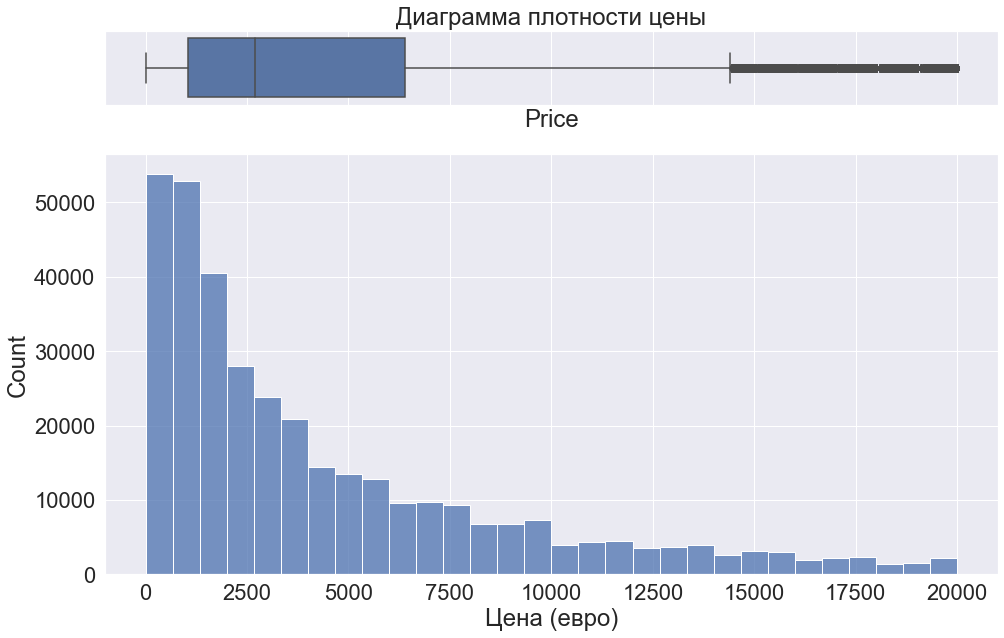

In [13]:
histogram_boxplot(df['Price'], bins = 30, title=f'Диаграмма плотности цены', xlabel="Цена (евро)")

In [14]:
display(df['Price'].describe())

count   354,369.000
mean      4,416.657
std       4,514.159
min           0.000
25%       1,050.000
50%       2,700.000
75%       6,400.000
max      20,000.000
Name: Price, dtype: float64

Выбросы по целевому показателю:
* Имеются нулевые значения цены.
* Четверть выборки машин стоит ниже тысячи евро. половина из них стоит дешевле 500 евро. Необходимо уточнить, представляют ли интерес данные по таким машинам.
* Четвёртый квартиль заканичвается не доходя до 15000 евро. Машины, имеющие более высокую стоимость, могут быть коллекционными экземплярами или ошибочно указанными значениями.


In [15]:
print(df[df['Price'] == 0]['NotRepaired'].value_counts())
print(df[df['Price'] >= 50]['NotRepaired'].value_counts())
print(df[df['Price'] >= 100]['NotRepaired'].value_counts())

no     8767
yes    2005
Name: NotRepaired, dtype: int64
no     308185
yes     33761
Name: NotRepaired, dtype: int64
no     307563
yes     33492
Name: NotRepaired, dtype: int64


Промежуточные выводы:
* Автомобили с нулевой ценой не имеют внятного физического объяснения своего существования в датасете и будут негативно влиять на обучение модели. Даже полностью разрушенные авто (total crash) продаются за какие-то скромные деньги.
* Количество автомобилей, переживших (серьёзные) ремонты на отсечке в 50 и 100 евро примерно одинаково и составляет порядка 33,5 тысячи.
* Исходя из проведённого анализа можно сделать вывод о безопасном удалении всех неаварийных авто со стоимостью ниже 100 евро.
* Также необходимо удалить все авто с нулевой ценой

In [16]:
df[df['Price'] > 15000].sample(20)

,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,NotRepaired
291321,15350,wagon,2013,auto,177,passat,150000,11,gasoline,volkswagen,no
248552,18500,suv,2011,manual,163,kuga,70000,6,gasoline,ford,no
218126,15600,coupe,2009,manual,190,a5,150000,2,gasoline,audi,no
2210,19300,coupe,2010,manual,190,other,100000,8,gasoline,audi,no
137811,18500,coupe,2010,manual,177,1er,90000,4,gasoline,bmw,no
194133,20000,coupe,2014,manual,160,cc,40000,6,petrol,volkswagen,no
49028,17900,bus,2007,manual,131,transporter,150000,12,gasoline,volkswagen,no
349662,18900,convertible,2011,manual,170,1er,80000,1,petrol,bmw,no
131957,18450,wagon,2012,manual,160,a3,40000,11,petrol,audi,no
52471,15900,bus,1994,manual,84,transporter,150000,6,petrol,volkswagen,no


Случайная выборка показывает, что речь идёт либо о премиальном сегменте автомобилей, либо о спецтехнике (автобусы, джипы). В этом случае аномальная стоимость нормальна. Вероятно, исследуемая площадка специализируется на продаже массовых потребительских автомобилей.

In [17]:
df = df.drop(df[(df['Price'] < 50)].index).reset_index(drop=True)
df = df.drop(df[(df['Price'] < 100) & (df['NotRepaired'] == 'yes')].index).reset_index(drop=True)
df = df[df['Price'] != 0].reset_index(drop=True)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 341677 entries, 0 to 341676
Data columns (total 11 columns):
 #   Column             Non-Null Count   Dtype 
---  ------             --------------   ----- 
 0   Price              341677 non-null  int64 
 1   VehicleType        341677 non-null  object
 2   RegistrationYear   341677 non-null  int64 
 3   Gearbox            341677 non-null  object
 4   Power              341677 non-null  int64 
 5   Model              341677 non-null  object
 6   Kilometer          341677 non-null  int64 
 7   RegistrationMonth  341677 non-null  int64 
 8   FuelType           341677 non-null  object
 9   Brand              341677 non-null  object
 10  NotRepaired        341677 non-null  object
dtypes: int64(5), object(6)
memory usage: 28.7+ MB


#### 1.2.4 Обработка дубликатов
После заполнения факторов необходимо повторить проверку на полные дубликаты и удалить найденные.

In [18]:
print(df.duplicated().sum())
df = df.drop_duplicates()
df.info()

31389
<class 'pandas.core.frame.DataFrame'>
Int64Index: 310288 entries, 0 to 341676
Data columns (total 11 columns):
 #   Column             Non-Null Count   Dtype 
---  ------             --------------   ----- 
 0   Price              310288 non-null  int64 
 1   VehicleType        310288 non-null  object
 2   RegistrationYear   310288 non-null  int64 
 3   Gearbox            310288 non-null  object
 4   Power              310288 non-null  int64 
 5   Model              310288 non-null  object
 6   Kilometer          310288 non-null  int64 
 7   RegistrationMonth  310288 non-null  int64 
 8   FuelType           310288 non-null  object
 9   Brand              310288 non-null  object
 10  NotRepaired        310288 non-null  object
dtypes: int64(5), object(6)
memory usage: 28.4+ MB


Проверим очищенные данные на мультиколлинеарность.

<AxesSubplot:>

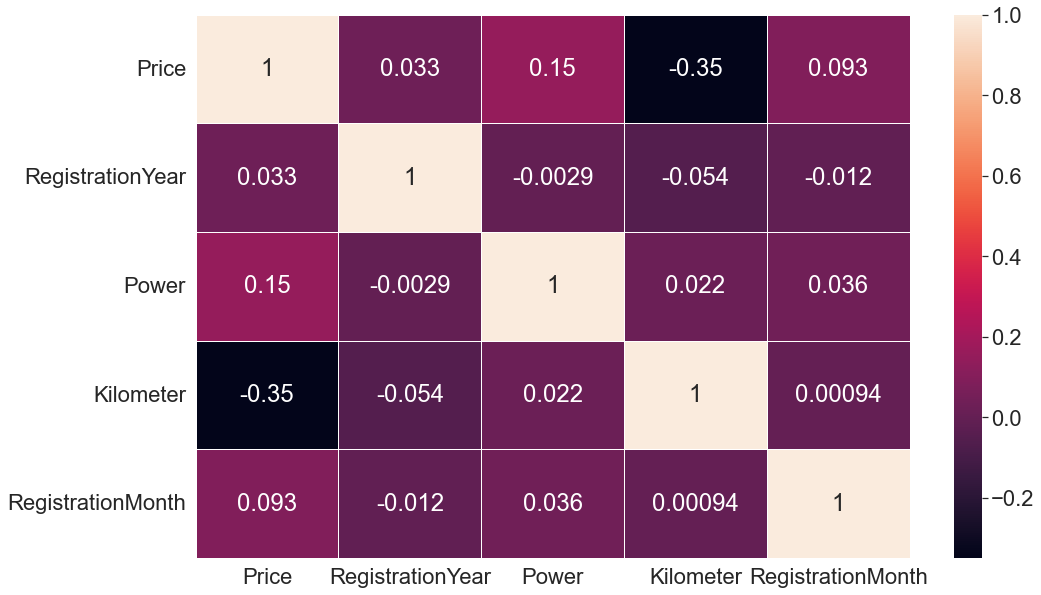

In [19]:
plt.rcParams['figure.figsize'] = (16.0, 10.0)
sns.heatmap(df.corr(), annot=True, linewidths=1, linecolor='white')

Взаимные корреляции по завершении обработки также не выявлены, удаление факторов не требуется

### 1.2.5 Анализ оставшихся аномалий

Оставим год регистрации между 1960 (потому что более ранние раритеты являются музейными экспонатами и продаются по другим каналам) и 2017 годом

In [20]:
print(df[df['RegistrationYear'] < 1960]['RegistrationYear'].count())
print(df[df['RegistrationYear'] > 2017]['RegistrationYear'].count())

301
3615


In [21]:
df = df.drop(df[(df['RegistrationYear'] < 1960) | (df['RegistrationYear'] > 2017)].index).reset_index(drop=True)

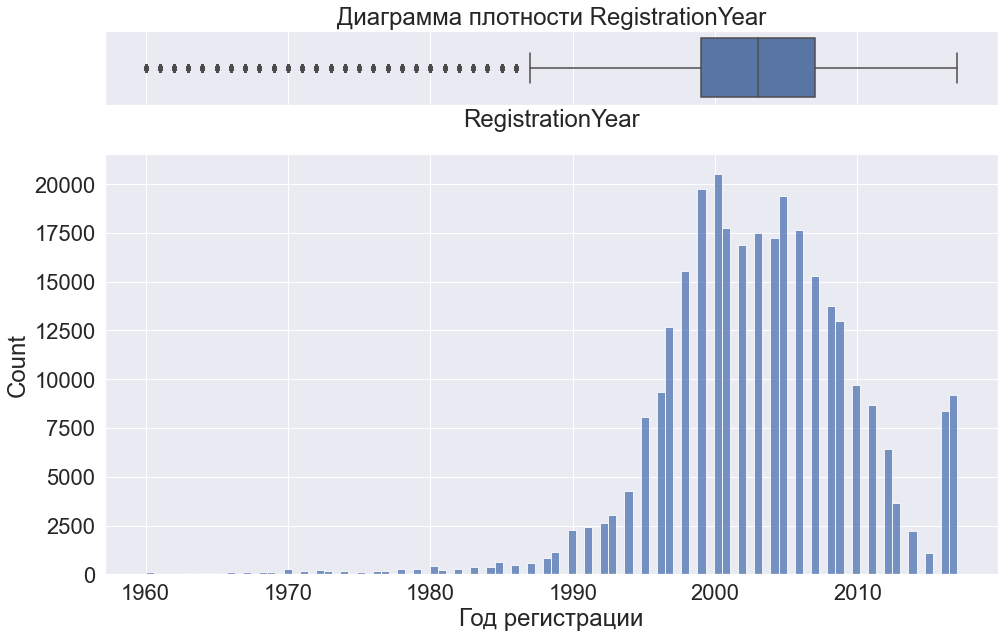

In [22]:
histogram_boxplot(df['RegistrationYear'], bins = 100, title=f'Диаграмма плотности RegistrationYear', xlabel="Год регистрации")

In [23]:
display(df['RegistrationYear'].describe())

count   306,372.000
mean      2,003.050
std           7.073
min       1,960.000
25%       1,999.000
50%       2,003.000
75%       2,007.000
max       2,017.000
Name: RegistrationYear, dtype: float64

Мощность оставим от 50 л.с. до 1000, по максимальной мощности двигателя легкового автомобиля.

In [24]:
print(df[df['Power'] < 50]['Power'].count())
print(df[df['Power'] > 1000]['Power'].count())

36341
269


In [25]:
df = df.drop(df[(df['Power'] < 50) | (df['Power'] > 1000)].index).reset_index(drop=True)

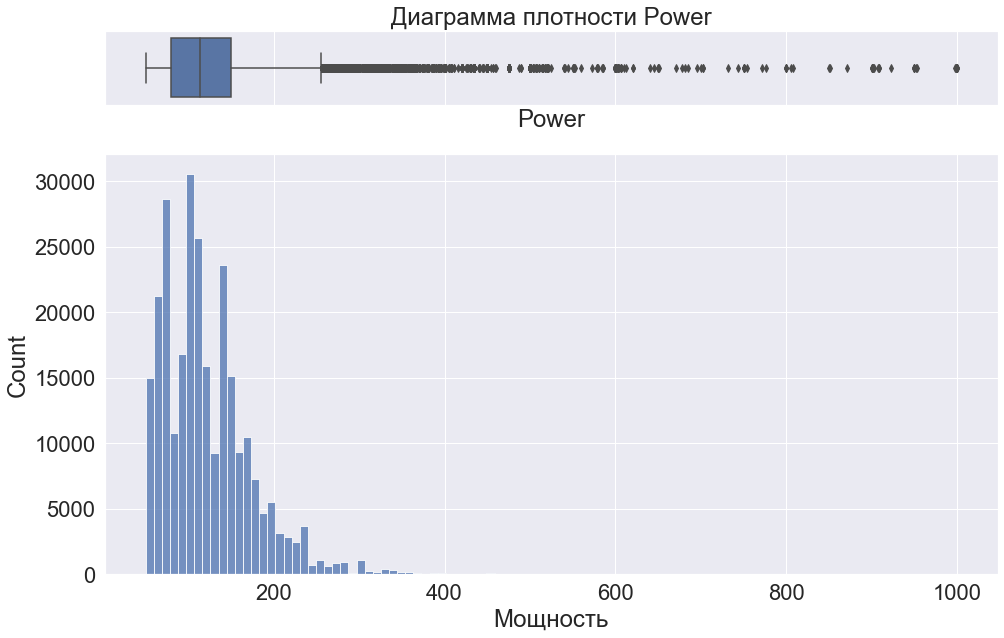

In [26]:
histogram_boxplot(df['Power'], bins = 100, title=f'Диаграмма плотности Power', xlabel="Мощность")

In [27]:
display(df['Power'].describe())

count   269,762.000
mean        122.097
std          54.163
min          50.000
25%          80.000
50%         114.000
75%         150.000
max       1,000.000
Name: Power, dtype: float64

### Выводы по шагу 1.2

<div class="alert alert-block alert-info">
    <b class="alert-heading"></b>
</div>

Исследовательский анализ и обработка данных
* Пропуски факторов VehicleType, FuelType, Gearbox заполнены медианным значением по бренду и модели
* Пропуски фактора NotRepaired заполнены значением 'no'
* Оставшиеся пропуски факторов VehicleType, Gearbox, Model, FuelType заполнены типом 'other'
* Удалены записи с нулевой заявленной ценой, а также записи с ценой менее EUR 100 без признака "Была в ремонте"
* Высокие цены на отдельные виды автомобилей оправданны, работа с верхним диапазоном цены не требуется
* Удалено 31391 полных дубликатов
* Факторы "год регистрации" и "мощность двигателя" очищены от аномальных значений

In [28]:
#КОД РЕВЬЮЕРА

df.describe()

,Price,RegistrationYear,Power,Kilometer,RegistrationMonth
count,"269,762.000","269,762.000","269,762.000","269,762.000","269,762.000"
mean,"4,883.131","2,003.314",122.097,"128,503.848",5.964
std,"4,614.373",6.612,54.163,"36,600.295",3.594
min,50.000,"1,960.000",50.000,"5,000.000",0.000
25%,"1,380.000","1,999.000",80.000,"125,000.000",3.000
50%,"3,200.000","2,003.000",114.000,"150,000.000",6.000
75%,"6,999.000","2,008.000",150.000,"150,000.000",9.000
max,"20,000.000","2,017.000","1,000.000","150,000.000",12.000


### Шаг 1.3 Подготовка датасета к обучению моделей. Кодирование и масштабирование факторов.

Так как будут использоваться различные модели, кодирование также будет разделено на три датасета:
- закодированные порядковые переменные с помощью One-hot encoding и отмасштабированные числовые параметры.
- закодированные с помощью OE классификаторы без масштабирования. 
- для бустинга будет датасет без масштабирования.

При небольшом числе значений категориальных факторв в использовании OE не было бы особой необходимости. Число факторов 300+ уже может начать влиять на глубину деревьев решений.

In [29]:
len(df['Model'].unique())

249

In [30]:
# кодирование One-Hot Encoding в режиме отбрасывания избыточного параметра
encode_columns = ['NotRepaired','VehicleType', 'Gearbox', 'Model', 'FuelType', 'Brand']
df_ohe = pd.get_dummies(df, drop_first=True, columns=encode_columns)
display(df_ohe.sample(10))

,Price,RegistrationYear,Power,Kilometer,RegistrationMonth,NotRepaired_yes,VehicleType_convertible,VehicleType_coupe,VehicleType_other,VehicleType_sedan,VehicleType_small,VehicleType_suv,VehicleType_wagon,Gearbox_manual,Model_145,Model_147,Model_156,Model_159,Model_1_reihe,Model_1er,Model_200,Model_2_reihe,Model_300c,Model_3_reihe,Model_3er,Model_4_reihe,Model_500,Model_5_reihe,Model_5er,Model_601,Model_6_reihe,Model_6er,Model_7er,Model_80,Model_850,Model_90,Model_900,Model_9000,Model_911,Model_a1,Model_a2,Model_a3,Model_a4,Model_a5,Model_a6,Model_a8,Model_a_klasse,Model_accord,Model_agila,Model_alhambra,Model_almera,Model_altea,Model_amarok,Model_antara,Model_arosa,Model_astra,Model_auris,Model_avensis,Model_aveo,Model_aygo,Model_b_klasse,Model_b_max,Model_beetle,Model_berlingo,Model_bora,Model_boxster,Model_bravo,Model_c1,Model_c2,Model_c3,Model_c4,Model_c5,Model_c_klasse,Model_c_max,Model_c_reihe,Model_caddy,Model_calibra,Model_captiva,Model_carisma,Model_carnival,Model_cayenne,Model_cc,Model_ceed,Model_charade,Model_cherokee,Model_citigo,Model_civic,Model_cl,Model_clio,Model_clk,Model_clubman,Model_colt,Model_combo,Model_cooper,Model_cordoba,Model_corolla,Model_corsa,Model_cr_reihe,Model_croma,Model_crossfire,Model_cuore,Model_cx_reihe,Model_defender,Model_delta,Model_discovery,Model_doblo,Model_ducato,Model_duster,Model_e_klasse,Model_elefantino,Model_eos,Model_escort,Model_espace,Model_exeo,Model_fabia,Model_fiesta,Model_focus,Model_forester,Model_forfour,Model_fortwo,Model_fox,Model_freelander,Model_fusion,Model_g_klasse,Model_galant,Model_galaxy,Model_getz,Model_gl,Model_glk,Model_golf,Model_grand,Model_i3,Model_i_reihe,Model_ibiza,Model_impreza,Model_insignia,Model_jazz,Model_jetta,Model_jimny,Model_juke,Model_justy,Model_ka,Model_kadett,Model_kaefer,Model_kalina,Model_kalos,Model_kangoo,Model_kappa,Model_kuga,Model_laguna,Model_lancer,Model_lanos,Model_legacy,Model_leon,Model_lodgy,Model_logan,Model_lupo,Model_lybra,Model_m_klasse,Model_m_reihe,Model_materia,Model_matiz,Model_megane,Model_meriva,Model_micra,Model_mii,Model_modus,Model_mondeo,Model_move,Model_musa,Model_mustang,Model_mx_reihe,Model_navara,Model_niva,Model_note,Model_nubira,Model_octavia,Model_omega,Model_one,Model_other,Model_outlander,Model_pajero,Model_panda,Model_passat,Model_phaeton,Model_picanto,Model_polo,Model_primera,Model_ptcruiser,Model_punto,Model_q3,Model_q5,Model_q7,Model_qashqai,Model_r19,Model_range_rover,Model_range_rover_evoque,Model_range_rover_sport,Model_rangerover,Model_rav,Model_rio,Model_roadster,Model_roomster,Model_rx_reihe,Model_s60,Model_s_klasse,Model_s_max,Model_s_type,Model_samara,Model_sandero,Model_santa,Model_scenic,Model_scirocco,Model_seicento,Model_serie_2,Model_serie_3,Model_sharan,Model_signum,Model_sirion,Model_sl,Model_slk,Model_sorento,Model_spark,Model_spider,Model_sportage,Model_sprinter,Model_stilo,Model_superb,Model_swift,Model_terios,Model_tigra,Model_tiguan,Model_toledo,Model_touareg,Model_touran,Model_transit,Model_transporter,Model_tt,Model_tucson,Model_twingo,Model_up,Model_v40,Model_v50,Model_v60,Model_v70,Model_v_klasse,Model_vectra,Model_verso,Model_viano,Model_vito,Model_vivaro,Model_voyager,Model_wrangler,Model_x_reihe,Model_x_trail,Model_x_type,Model_xc_reihe,Model_yaris,Model_yeti,Model_ypsilon,Model_z_reihe,Model_zafira,FuelType_electric,FuelType_gasoline,FuelType_hybrid,FuelType_lpg,FuelType_other,FuelType_petrol,Brand_audi,Brand_bmw,Brand_chevrolet,Brand_chrysler,Brand_citroen,Brand_dacia,Brand_daewoo,Brand_daihatsu,Brand_fiat,Brand_ford,Brand_honda,Brand_hyundai,Brand_jaguar,Brand_jeep,Brand_kia,Brand_lada,Brand_lancia,Brand_land_rover,Brand_mazda,Brand_mercedes_benz,Brand_mini,Brand_mitsubishi,Brand_nissan,Brand_opel,Brand_peugeot,Brand_porsche,Brand_renault,Brand_rover,Brand_saab,Brand_seat,Brand_skoda,Brand_smart,Brand_sonstige_autos,Brand_subaru,Brand_suzuki,Brand_toyota,Brand_trabant,Brand_volkswagen,Brand_volvo
675,2000,1998,204,150000,2,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0

In [31]:
# порядковое кодирование
encode_columns = ['NotRepaired','VehicleType', 'Gearbox', 'Model', 'FuelType', 'Brand']
df_oe = df.copy()

encoder = OrdinalEncoder()
df_oe[encode_columns] = encoder.fit_transform(df_oe[encode_columns]).astype('int64')
display(df_oe.sample(10))

,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,NotRepaired
225618,950,2,1999,1,170,166,150000,7,6,2,0
34129,1300,4,2001,1,150,116,150000,8,6,38,0
267174,8500,5,2013,1,69,166,40000,7,6,24,0
168738,3490,4,2001,1,131,28,150000,2,2,1,0
212027,1390,7,2002,0,170,11,150000,7,6,2,0
113483,1480,5,1998,1,75,116,150000,3,6,38,0
121609,13400,5,2012,1,86,26,40000,10,6,1,0
92840,4850,7,2007,1,140,170,150000,11,2,38,0
68680,2499,5,2005,1,54,107,150000,9,6,38,0
56245,1600,0,2004,1,101,248,150000,0,6,24,0


In [32]:
# Подготовим тренировочную, тестовую и валидационные выборки по данным OHE
# Пропорции: 3:1:1

target_ohe = df_ohe['Price']
features_ohe = df_ohe.drop('Price', axis=1)

features_train_ohe, features_combined_ohe, target_train_ohe, target_combined_ohe = train_test_split(features_ohe, target_ohe,
                                                                                    test_size=0.4, random_state=12345)

features_test_ohe, features_valid_ohe, target_test_ohe, target_valid_ohe = train_test_split(features_combined_ohe, target_combined_ohe,
                                                                            test_size=0.5, random_state=12345)


print('Размер обучающей выборки OHE:\t\t', features_train_ohe.shape)
print('Размер валидационной выборки выборки OHE:\t', features_valid_ohe.shape)
print('Размер тестовой выборки OHE:\t\t', features_test_ohe.shape)

Размер обучающей выборки OHE:		 (161857, 306)
Размер валидационной выборки выборки OHE:	 (53953, 306)
Размер тестовой выборки OHE:		 (53952, 306)


In [33]:
# Подготовим тренировочную, тестовую и валидационные выборки по данным OE
# Пропорции: 3:1:1

target_oe = df_oe['Price']
features_oe = df_oe.drop('Price', axis=1)

features_train_oe, features_combined_oe, target_train_oe, target_combined_oe = train_test_split(features_oe, target_oe,
                                                                                    test_size=0.4, random_state=12345)

features_test_oe, features_valid_oe, target_test_oe, target_valid_oe = train_test_split(features_combined_oe, target_combined_oe,
                                                                            test_size=0.5, random_state=12345)


print('Размер обучающей выборки OE:\t\t', features_train_oe.shape)
print('Размер валидационной выборки выборки OE:', features_valid_oe.shape)
print('Размер тестовой выборки OE:\t\t', features_test_oe.shape)

Размер обучающей выборки OE:		 (161857, 10)
Размер валидационной выборки выборки OE: (53953, 10)
Размер тестовой выборки OE:		 (53952, 10)


In [34]:
# Подготовим тренировочную, тестовую и валидационные выборки по данным без кодирования
# Пропорции: 3:1:1

df_nc = df.copy()

# перевод категориальных значений в соответствующий тип для бустинга
for column in df_nc.columns:
    col_type = df_nc[column].dtype
    if col_type == 'object':
        df_nc[column] = df_nc[column].astype('category')

target_nc = df_nc['Price']
features_nc = df_nc.drop('Price', axis=1)

features_train_nc, features_combined_nc, target_train_nc, target_combined_nc = train_test_split(features_nc, target_nc,
                                                                                    test_size=0.4, random_state=12345)

features_test_nc, features_valid_nc, target_test_nc, target_valid_nc = train_test_split(features_combined_nc, target_combined_nc,
                                                                            test_size=0.5, random_state=12345)


print('Размер обучающей выборки NC:\t\t', features_train_nc.shape)
print('Размер валидационной выборки выборки NC:\t', features_valid_nc.shape)
print('Размер тестовой выборки NC:\t\t', features_test_nc.shape)

Размер обучающей выборки NC:		 (161857, 10)
Размер валидационной выборки выборки NC:	 (53953, 10)
Размер тестовой выборки NC:		 (53952, 10)


In [35]:
# Подготовим функцию для масштабирования
def scale_factors(features_train, features_test):
    columns_numeric = ['RegistrationYear', 'RegistrationMonth', 'Power', 'Kilometer']
    
    scaler = StandardScaler()
    scaler.fit(features_train[columns_numeric])
    
    features_train.loc[:,columns_numeric] = scaler.transform(features_train[columns_numeric])
    features_test.loc[:,columns_numeric] = scaler.transform(features_test[columns_numeric])
    
    return features_train, features_test

In [36]:
# Масштабирование датасета с OHE-кодированием
features_train_ohe, features_test_ohe = scale_factors(features_train_ohe.copy(), features_test_ohe.copy())
features_train_ohe.describe() # контроль результата масштабирования

,RegistrationYear,Power,Kilometer,RegistrationMonth,NotRepaired_yes,VehicleType_convertible,VehicleType_coupe,VehicleType_other,VehicleType_sedan,VehicleType_small,VehicleType_suv,VehicleType_wagon,Gearbox_manual,Model_145,Model_147,Model_156,Model_159,Model_1_reihe,Model_1er,Model_200,Model_2_reihe,Model_300c,Model_3_reihe,Model_3er,Model_4_reihe,Model_500,Model_5_reihe,Model_5er,Model_601,Model_6_reihe,Model_6er,Model_7er,Model_80,Model_850,Model_90,Model_900,Model_9000,Model_911,Model_a1,Model_a2,Model_a3,Model_a4,Model_a5,Model_a6,Model_a8,Model_a_klasse,Model_accord,Model_agila,Model_alhambra,Model_almera,Model_altea,Model_amarok,Model_antara,Model_arosa,Model_astra,Model_auris,Model_avensis,Model_aveo,Model_aygo,Model_b_klasse,Model_b_max,Model_beetle,Model_berlingo,Model_bora,Model_boxster,Model_bravo,Model_c1,Model_c2,Model_c3,Model_c4,Model_c5,Model_c_klasse,Model_c_max,Model_c_reihe,Model_caddy,Model_calibra,Model_captiva,Model_carisma,Model_carnival,Model_cayenne,Model_cc,Model_ceed,Model_charade,Model_cherokee,Model_citigo,Model_civic,Model_cl,Model_clio,Model_clk,Model_clubman,Model_colt,Model_combo,Model_cooper,Model_cordoba,Model_corolla,Model_corsa,Model_cr_reihe,Model_croma,Model_crossfire,Model_cuore,Model_cx_reihe,Model_defender,Model_delta,Model_discovery,Model_doblo,Model_ducato,Model_duster,Model_e_klasse,Model_elefantino,Model_eos,Model_escort,Model_espace,Model_exeo,Model_fabia,Model_fiesta,Model_focus,Model_forester,Model_forfour,Model_fortwo,Model_fox,Model_freelander,Model_fusion,Model_g_klasse,Model_galant,Model_galaxy,Model_getz,Model_gl,Model_glk,Model_golf,Model_grand,Model_i3,Model_i_reihe,Model_ibiza,Model_impreza,Model_insignia,Model_jazz,Model_jetta,Model_jimny,Model_juke,Model_justy,Model_ka,Model_kadett,Model_kaefer,Model_kalina,Model_kalos,Model_kangoo,Model_kappa,Model_kuga,Model_laguna,Model_lancer,Model_lanos,Model_legacy,Model_leon,Model_lodgy,Model_logan,Model_lupo,Model_lybra,Model_m_klasse,Model_m_reihe,Model_materia,Model_matiz,Model_megane,Model_meriva,Model_micra,Model_mii,Model_modus,Model_mondeo,Model_move,Model_musa,Model_mustang,Model_mx_reihe,Model_navara,Model_niva,Model_note,Model_nubira,Model_octavia,Model_omega,Model_one,Model_other,Model_outlander,Model_pajero,Model_panda,Model_passat,Model_phaeton,Model_picanto,Model_polo,Model_primera,Model_ptcruiser,Model_punto,Model_q3,Model_q5,Model_q7,Model_qashqai,Model_r19,Model_range_rover,Model_range_rover_evoque,Model_range_rover_sport,Model_rangerover,Model_rav,Model_rio,Model_roadster,Model_roomster,Model_rx_reihe,Model_s60,Model_s_klasse,Model_s_max,Model_s_type,Model_samara,Model_sandero,Model_santa,Model_scenic,Model_scirocco,Model_seicento,Model_serie_2,Model_serie_3,Model_sharan,Model_signum,Model_sirion,Model_sl,Model_slk,Model_sorento,Model_spark,Model_spider,Model_sportage,Model_sprinter,Model_stilo,Model_superb,Model_swift,Model_terios,Model_tigra,Model_tiguan,Model_toledo,Model_touareg,Model_touran,Model_transit,Model_transporter,Model_tt,Model_tucson,Model_twingo,Model_up,Model_v40,Model_v50,Model_v60,Model_v70,Model_v_klasse,Model_vectra,Model_verso,Model_viano,Model_vito,Model_vivaro,Model_voyager,Model_wrangler,Model_x_reihe,Model_x_trail,Model_x_type,Model_xc_reihe,Model_yaris,Model_yeti,Model_ypsilon,Model_z_reihe,Model_zafira,FuelType_electric,FuelType_gasoline,FuelType_hybrid,FuelType_lpg,FuelType_other,FuelType_petrol,Brand_audi,Brand_bmw,Brand_chevrolet,Brand_chrysler,Brand_citroen,Brand_dacia,Brand_daewoo,Brand_daihatsu,Brand_fiat,Brand_ford,Brand_honda,Brand_hyundai,Brand_jaguar,Brand_jeep,Brand_kia,Brand_lada,Brand_lancia,Brand_land_rover,Brand_mazda,Brand_mercedes_benz,Brand_mini,Brand_mitsubishi,Brand_nissan,Brand_opel,Brand_peugeot,Brand_porsche,Brand_renault,Brand_rover,Brand_saab,Brand_seat,Brand_skoda,Brand_smart,Brand_sonstige_autos,Brand_subaru,Brand_suzuki,Brand_toyota,Brand_trabant,Brand_volkswagen,Brand_volvo
count,"161,857.000","161,857.000","161,857.000","161,857.000","161,857.000","161,8

### Выводы по шагу 1

<div class="alert alert-block alert-info">
    <b class="alert-heading"></b>
</div>

Данные загружены, проведён предварительный анализ:
* Колонки поименованы в нотации Camel Case, Это не мешает дальнейшей работе.
* Выявлено четыре набора полных дубликатов
* Выявлены выбросы в цене (нулевые и сверхвысокие цены), средние значения смещены в сторону увеличения. Высокая цена может быть у небольшого количества раритетных моделей, в этом случае важно определиться, стоит ли её включать в обучение.
* Факторы "год регистрации" и "мощность двигателя" содержат значения с обеих сторон распределения, имеющие сомнительный физический смысл.
* Выявлены пропуски в данных факторов VehicleType, Gearbox, Model, FuelType, NotRepaired
* Часть колонок (DateCrawled, DateCreated, PostalCode, LastSeen, NumberOfPictures) является метаданными и должна быть удалена перед обучением моделей.
* Выявлены корреляции цены и пробега, мощности двигателя и месяца регистрации.

Исследовательский анализ и обработка данных
* Пропуски факторов VehicleType, FuelType, Gearbox заполнены медианным значением по бренду и модели
* Пропуски фактора NotRepaired заполнены значением 'no'
* Оставшиеся пропуски факторов VehicleType, Gearbox, Model, FuelType заполнены типом 'other'
* Удалены записи с нулевой заявленной ценой, а также записи с ценой менее EUR 100 без признака "Была в ремонте"
* Высокие цены на отдельные виды автомобилей оправданны, работа с верхним диапазоном цены не требуется
* Удалено 31391 полных дубликатов

Кодирование и масштабирование факторов
* Подготовлены датасеты для обучения моделей с кодированием OHE, OE и без кодирования. Числовые факторы промасштабированы в OHE датасете.

## Шаг 2. Обучение моделей

In [39]:
# функция оценки с помощью метрики RMSE
def rmse_score(target, predictions):
    rmse = mean_squared_error(target, predictions, squared=False)
    return rmse

scorer = make_scorer(rmse_score, greater_is_better=False)

In [40]:
rmse_results = pd.DataFrame({
    'model': [],
    'hyper_params': [],
    'rmse':[]
})


# функция, добавляющая результаты в общую таблицу
def add_result(model_desc, hyper_params, rmse):
    rmse_results.loc[rmse_results.size] = [model_desc, hyper_params, rmse]
    rmse_results.drop_duplicates(inplace=True)

### 2.1 Dummy регрессор

In [41]:
model = DummyRegressor(strategy='mean')
model.fit(features_train_ohe, target_train_ohe)
    
predictions = pd.Series(model.predict(features_valid_ohe))
rmse = mean_squared_error(target_valid_ohe, predictions, squared=False)

add_result('DummyRegressor', "", rmse)
display(rmse_results)

,model,hyper_params,rmse
0,DummyRegressor,,"4,614.064"


### 2.2 Линейная регрессия

In [42]:
%%time

model_lr = LinearRegression()

parameters = {
    'fit_intercept':[True,False]
}

grid_lr = GridSearchCV(model_lr, parameters, cv=5, verbose=0, scoring=scorer)
grid_lr.fit(features_train_ohe, target_train_ohe)

add_result('LinearRegression', str(grid_lr.best_params_), grid_lr.best_score_)
display(rmse_results)

,model,hyper_params,rmse
0,DummyRegressor,,"4,614.064"
3,LinearRegression,{'fit_intercept': False},"-441,208,406.730"


CPU times: total: 1min 48s
Wall time: 19.1 s


### 2.3 Дерево решений

In [43]:
%%time

model_dtree = DecisionTreeRegressor(random_state=12345)
    
tree_params = {
    'max_depth': range(1,15),
    'min_samples_split': range(2,7)
}

grid_dtree = GridSearchCV(model_dtree, tree_params, cv=5, verbose=0, scoring=scorer)
grid_dtree.fit(features_train_oe, target_train_oe)

add_result('DecisionTreeRegressor', str(grid_dtree.best_params_), grid_dtree.best_score_)
display(rmse_results)

,model,hyper_params,rmse
0,DummyRegressor,,"4,614.064"
3,LinearRegression,{'fit_intercept': False},"-441,208,406.730"
6,DecisionTreeRegressor,"{'max_depth': 13, 'min_samples_split': 6}","-1,938.375"


CPU times: total: 1min 4s
Wall time: 1min 3s


### 2.4 Случайный лес

In [44]:
%%time

model_forest = RandomForestRegressor(random_state=12345)
    
forest_params = {
    'n_estimators': [50, 100, 200, 500, 1000],
    'max_depth': range(3,11)
}

grid_forest = GridSearchCV(model_forest, forest_params, cv=5, verbose=0, scoring=scorer)
grid_forest.fit(features_train_oe, target_train_oe)

add_result('RandomForestRegressor', str(grid_forest.best_params_), grid_forest.best_score_)
display(rmse_results)

,model,hyper_params,rmse
0,DummyRegressor,,"4,614.064"
3,LinearRegression,{'fit_intercept': False},"-441,208,406.730"
6,DecisionTreeRegressor,"{'max_depth': 13, 'min_samples_split': 6}","-1,938.375"
9,RandomForestRegressor,"{'max_depth': 10, 'n_estimators': 1000}","-1,878.767"


CPU times: total: 2h 4min 16s
Wall time: 2h 4min 21s


### 2.5 Бустинг с помощью библиотеки LightGBM

In [45]:
%%time

model_gbm = LGBMRegressor(random_state=12345)
    
gbm_params = {
    'n_estimators': [50, 100, 500],
    'num_leaves': [21, 31, 41], 
    'learning_rate':[0.01, .04, 0.06]
}

grid_gbm = GridSearchCV(model_gbm, gbm_params, cv=5, verbose=0, scoring=scorer)
grid_gbm.fit(features_train_oe, target_train_oe)

add_result('LGBMRegressor', str(grid_gbm.best_params_), grid_gbm.best_score_)
display(rmse_results)

,model,hyper_params,rmse
0,DummyRegressor,,"4,614.064"
3,LinearRegression,{'fit_intercept': False},"-441,208,406.730"
6,DecisionTreeRegressor,"{'max_depth': 13, 'min_samples_split': 6}","-1,938.375"
9,RandomForestRegressor,"{'max_depth': 10, 'n_estimators': 1000}","-1,878.767"
12,LGBMRegressor,"{'learning_rate': 0.06, 'n_estimators': 500, 'num_leaves': 41}","-1,614.668"


CPU times: total: 36min 12s
Wall time: 1min 32s


### 2.6 Бустинг с помощью библиотеки CatBoost

In [46]:
%%time

categories = ['VehicleType', 'Gearbox', 'Model', 'FuelType', 'Brand', 'NotRepaired']

model_cbr = CatBoostRegressor(cat_features = categories, loss_function="RMSE", verbose=0)

cbr_params = {
    'learning_rate': [0.03, 0.1, 0.5],
    'iterations': [150, 500]
}

grid_cbr = GridSearchCV(model_cbr, cbr_params, cv=5, scoring=scorer)

grid_cbr.fit(features_train_nc, target_train_nc)

add_result('CatBoostRegressor', str(grid_cbr.best_params_), grid_cbr.best_score_)
display(rmse_results)

,model,hyper_params,rmse
0,DummyRegressor,,"4,614.064"
3,LinearRegression,{'fit_intercept': False},"-441,208,406.730"
6,DecisionTreeRegressor,"{'max_depth': 13, 'min_samples_split': 6}","-1,938.375"
9,RandomForestRegressor,"{'max_depth': 10, 'n_estimators': 1000}","-1,878.767"
12,LGBMRegressor,"{'learning_rate': 0.06, 'n_estimators': 500, 'num_leaves': 41}","-1,614.668"
15,CatBoostRegressor,"{'iterations': 500, 'learning_rate': 0.5}","-1,623.800"


CPU times: total: 19min 8s
Wall time: 34min 47s


### Выводы по шагу 2

<div class="alert alert-block alert-info">
    <b class="alert-heading"></b>
</div>

* Выполнено обучение моделей линейной регресии, решающего дерева, случайного леса
* Выполнен градиентный бустинг с помощью библиотек LightGBM и CatBoost
* Все модели оценивались кросс-валидацией с помощью кастомного скорера для GridSearchCV на базе метрики RMSE
* Наилучший результат показала модель LGBMRegressor (RMSE=1614) с параметрами {'learning_rate': 0.06, 'n_estimators': 500, 'num_leaves': 41}
* Проведено тестирование адекватности моделей с помощью DummyRegressor. Модели, за исключением линейной регрессии, адекватны. Это даёт повод предположить, что исследуемая функция изменения цены не является линейной.

## Анализ моделей

В данном разделе модели с найденными оптимальными гиперпараметрами будут проанализированы на валидационной выборке, лучшие будут протестированы на тестовой выборке. Помимо метрики качества будет оцениваться скорость работы.

In [47]:
# функция оценки метрик качества и производительности модели
def calculate_model_performance(model, features_train, target_train, features_test, target_test):
    
    start_time_fit = time.time()
    model.fit(features_train, target_train)
    stop_time_fit = time.time()
    
    fit_time = stop_time_fit - start_time_fit
    
    start_time_predict = time.time()
    predictions = model.predict(features_test)
    stop_time_predict = time.time()
    
    predict_time = stop_time_predict - start_time_predict
    
    rmse = mean_squared_error(target_test, predictions, squared=False)
    
    return rmse, fit_time, predict_time

In [48]:
model_performance = pd.DataFrame({
    'model': [],
    'hyper_params': [],
    'rmse':[],
    'fit_time': [],
    'predict_time':[],
    'total_time':[]
})


# функция, добавляющая результаты в общую таблицу
def get_performance(model_desc, hyper_params, model, features_train, target_train, features_test, target_test):
    rmse, fit_time, predict_time = calculate_model_performance(model,
                                                               features_train, target_train, features_test, target_test)
    total_time = fit_time + predict_time
    model_performance.loc[model_performance.size] = [model_desc, hyper_params, rmse, fit_time, predict_time, total_time]
    model_performance.drop_duplicates(inplace=True)

In [49]:
# Оценка модели линейной регрессии
model_lr = LinearRegression(**grid_lr.best_params_)
params = str(grid_lr.best_params_)
get_performance('LinearRegression', params, model_lr, 
                features_train_ohe, target_train_ohe, features_valid_ohe, target_valid_ohe)
display(model_performance)

,model,hyper_params,rmse,fit_time,predict_time,total_time
0,LinearRegression,{'fit_intercept': False},"211,462,857.371",1.904,0.123,2.027


In [50]:
# Оценка модели дерева решений
model_dt = DecisionTreeRegressor(**grid_dtree.best_params_, random_state=12345)
params = str(grid_dtree.best_params_)
get_performance('DecisionTreeRegressor', params, model_dt, 
                features_train_oe, target_train_oe, features_valid_oe, target_valid_oe)
display(model_performance)

,model,hyper_params,rmse,fit_time,predict_time,total_time
0,LinearRegression,{'fit_intercept': False},"211,462,857.371",1.904,0.123,2.027
6,DecisionTreeRegressor,"{'max_depth': 13, 'min_samples_split': 6}","1,918.128",0.342,0.010,0.352


In [51]:
# Оценка модели случайного леса
model_rf = RandomForestRegressor(**grid_forest.best_params_, random_state=12345)
params = str(grid_forest.best_params_)
get_performance('RandomForestRegressor', params, model_rf, 
                features_train_oe, target_train_oe, features_valid_oe, target_valid_oe)
display(model_performance)

,model,hyper_params,rmse,fit_time,predict_time,total_time
0,LinearRegression,{'fit_intercept': False},"211,462,857.371",1.904,0.123,2.027
6,DecisionTreeRegressor,"{'max_depth': 13, 'min_samples_split': 6}","1,918.128",0.342,0.010,0.352
12,RandomForestRegressor,"{'max_depth': 10, 'n_estimators': 1000}","1,883.737",180.362,4.335,184.698


In [52]:
# Оценка модели Light GBM
model_lgbm = LGBMRegressor(**grid_gbm.best_params_, random_state=12345)
params = str(grid_gbm.best_params_)
get_performance('LGBMRegressor', params, model_lgbm, 
                features_train_oe, target_train_oe, features_valid_oe, target_valid_oe)
display(model_performance)

,model,hyper_params,rmse,fit_time,predict_time,total_time
0,LinearRegression,{'fit_intercept': False},"211,462,857.371",1.904,0.123,2.027
6,DecisionTreeRegressor,"{'max_depth': 13, 'min_samples_split': 6}","1,918.128",0.342,0.010,0.352
12,RandomForestRegressor,"{'max_depth': 10, 'n_estimators': 1000}","1,883.737",180.362,4.335,184.698
18,LGBMRegressor,"{'learning_rate': 0.06, 'n_estimators': 500, 'num_leaves': 41}","1,613.567",1.490,0.085,1.574


In [53]:
# Оценка модели CatBoost
categories = ['VehicleType', 'Gearbox', 'Model', 'FuelType', 'Brand', 'NotRepaired']

model_cb = CatBoostRegressor(**grid_cbr.best_params_, cat_features=categories, verbose=0, random_state=12345)

params = str(grid_cbr.best_params_)
get_performance('CatBoostRegressor', params, model_cb, 
                features_train_nc, target_train_nc, features_valid_nc, target_valid_nc)
display(model_performance)

,model,hyper_params,rmse,fit_time,predict_time,total_time
0,LinearRegression,{'fit_intercept': False},"211,462,857.371",1.904,0.123,2.027
6,DecisionTreeRegressor,"{'max_depth': 13, 'min_samples_split': 6}","1,918.128",0.342,0.010,0.352
12,RandomForestRegressor,"{'max_depth': 10, 'n_estimators': 1000}","1,883.737",180.362,4.335,184.698
18,LGBMRegressor,"{'learning_rate': 0.06, 'n_estimators': 500, 'num_leaves': 41}","1,613.567",1.490,0.085,1.574
24,CatBoostRegressor,"{'iterations': 500, 'learning_rate': 0.5}","1,621.355",107.046,0.053,107.099


In [54]:
# Оценка модели Light GBM на тестовой выборке
model_lgbmt = LGBMRegressor(**grid_gbm.best_params_, random_state=12345)
params = str(grid_gbm.best_params_)
get_performance('LGBMRegressor (test data)', params, model_lgbmt, 
                features_train_oe, target_train_oe, features_test_oe, target_test_oe)
display(model_performance)

,model,hyper_params,rmse,fit_time,predict_time,total_time
0,LinearRegression,{'fit_intercept': False},"211,462,857.371",1.904,0.123,2.027
6,DecisionTreeRegressor,"{'max_depth': 13, 'min_samples_split': 6}","1,918.128",0.342,0.010,0.352
12,RandomForestRegressor,"{'max_depth': 10, 'n_estimators': 1000}","1,883.737",180.362,4.335,184.698
18,LGBMRegressor,"{'learning_rate': 0.06, 'n_estimators': 500, 'num_leaves': 41}","1,613.567",1.490,0.085,1.574
24,CatBoostRegressor,"{'iterations': 500, 'learning_rate': 0.5}","1,621.355",107.046,0.053,107.099
30,LGBMRegressor (test data),"{'learning_rate': 0.06, 'n_estimators': 500, 'num_leaves': 41}","1,616.187",1.485,0.085,1.570


In [55]:
# Оценка модели CatBoost на тестовой выборке
categories = ['VehicleType', 'Gearbox', 'Model', 'FuelType', 'Brand', 'NotRepaired']

model_cbt = CatBoostRegressor(**grid_cbr.best_params_, cat_features=categories, verbose=0, random_state=12345)

params = str(grid_cbr.best_params_)
get_performance('CatBoostRegressor (test)', params, model_cbt, 
                features_train_nc, target_train_nc, features_test_nc, target_test_nc)
display(model_performance)

,model,hyper_params,rmse,fit_time,predict_time,total_time
0,LinearRegression,{'fit_intercept': False},"211,462,857.371",1.904,0.123,2.027
6,DecisionTreeRegressor,"{'max_depth': 13, 'min_samples_split': 6}","1,918.128",0.342,0.010,0.352
12,RandomForestRegressor,"{'max_depth': 10, 'n_estimators': 1000}","1,883.737",180.362,4.335,184.698
18,LGBMRegressor,"{'learning_rate': 0.06, 'n_estimators': 500, 'num_leaves': 41}","1,613.567",1.490,0.085,1.574
24,CatBoostRegressor,"{'iterations': 500, 'learning_rate': 0.5}","1,621.355",107.046,0.053,107.099
30,LGBMRegressor (test data),"{'learning_rate': 0.06, 'n_estimators': 500, 'num_leaves': 41}","1,616.187",1.485,0.085,1.570
36,CatBoostRegressor (test),"{'iterations': 500, 'learning_rate': 0.5}","1,625.024",108.696,0.047,108.743


### Выводы по шагу 3

<div class="alert alert-block alert-info">
    <b class="alert-heading"></b>
</div>

* Проведена оценка моделей линейной регресии, решающего дерева, случайного леса, LightGBM и CatBoost по критериям качества метрики RMSE и скорости работы
* Наилучшие параметры качества с отрывом показывают обе модели градиентного бустинга. При этом CatBoostRegressor требует в десятки раз больше времени на обучение, но примерно в два раза быстрее отрабатывает на предсказаниях.

### Общий вывод

<div class="alert alert-block alert-info">
    <b class="alert-heading"></b>
</div>

Исходя из заявленных заказчиком критериев:
* качество предсказания,
* скорость предсказания,
* время обучения,
выбор остаётся лишь между двумя моделями бустинга.

Заявленные критерии не позволяют указать на одну модель: по ТЗ непонятна нагрузка на новое приложение и требования к инфраструктуре и процессу работы с данными (архитектура данных и частота обновления данных обучения).

Для систем с высокой нагрузкой можно порекомендовать CatBoost и выверенные процессы ETL и машинного обучения.

LightGBM выглядит более сбалансированными решением для сценариев со средней и низкой нагрузкой.
